<a href="https://colab.research.google.com/github/KarinaJoanna/Practica2_2_VA/blob/main/Practica_Vision_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

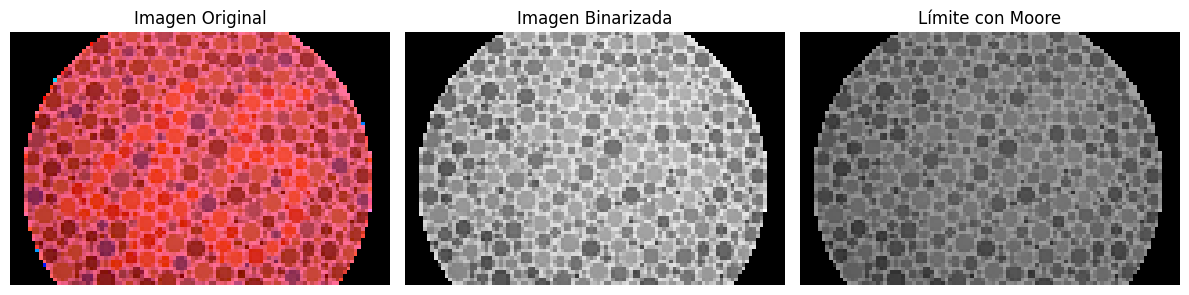

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_contour_moore(imagen_binarizada):
    contornos = []

    # Encuentra el primer píxel activo (valor 255) en la imagen binarizada
    inicio = None
    for y in range(imagen_binarizada.shape[0]):
        for x in range(imagen_binarizada.shape[1]):
            if imagen_binarizada[y, x] == 255:
                inicio = (x, y)
                contornos.append(inicio)
                break
        if inicio:
            break

    if not inicio:
        return contornos

    # Definir los desplazamientos en los 8 vecinos (Moore)
    desplazamientos = [(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0)]

    # Recorre el contorno siguiendo el algoritmo de Moore
    actual = inicio
    while True:
        siguiente_encontrado = False
        for desplazamiento in desplazamientos:
            siguiente = (actual[0] + desplazamiento[0], actual[1] + desplazamiento[1])
            if (0 <= siguiente[0] < imagen_binarizada.shape[1] and
                    0 <= siguiente[1] < imagen_binarizada.shape[0] and
                    imagen_binarizada[siguiente[1], siguiente[0]] == 255):
                contornos.append(siguiente)
                actual = siguiente
                siguiente_encontrado = True
                if actual == inicio:
                    break
        if not siguiente_encontrado or actual == inicio:
            break

    return contornos

# Ejemplo de uso:
imagen = cv2.imread('ishihara-18.png', cv2.IMREAD_COLOR)
imagen_binarizada = cv2.imread('ishihara-18.png', cv2.IMREAD_GRAYSCALE)

contornos = find_contour_moore(imagen_binarizada)

# Crea una copia de la imagen binarizada en color
imagen_con_contornos = cv2.cvtColor(imagen_binarizada, cv2.COLOR_GRAY2BGR)

# Dibujar los contornos en la copia de la imagen binarizada
for punto in contornos:
    x, y = punto
    imagen_con_contornos[y, x] = [0, 255, 255]

# Crear un subplot
plt.figure(figsize=(12, 4))

# Mostrar la imagen original
plt.subplot(131)
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.title('Imagen Original')
plt.axis('off')

# Mostrar la imagen binarizada
plt.subplot(132)
plt.imshow(imagen_binarizada, cmap='gray')
plt.title('Imagen Binarizada')
plt.axis('off')

# Mostrar la imagen binarizada con el contorno en rojo
plt.subplot(133)
plt.imshow(cv2.cvtColor(imagen_con_contornos, cv2.COLOR_BGR2RGB))
plt.title('Límite con Moore')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Función para normalizar el código de Freeman a la rotación ocupando la primera diferencia

def normalize_freeman_code(code):
    normalized_code = []
    for i in range(len(code)):
        diff = (code[i] - code[i - 1] + 8) % 8
        normalized_code.append(diff)
    return normalized_code


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def freeman_contour(image, connectivity=8):
    if connectivity != 4 and connectivity != 8:
        raise ValueError("La conectividad debe ser 4 o 8")

    def find_next(p, d):
        dx, dy = d
        return p[0] + dx, p[1] + dy

    def is_valid(p, image_shape):
        return 0 <= p[0] < image_shape[1] and 0 <= p[1] < image_shape[0]

    contour = []
    freeman_code = []

    if connectivity == 4:
        codigo_freeman = [0, 1, 2, 3]
        directions = [(1, 0), (0, -1), (-1, 0), (0, 1)]
    else:
        codigo_freeman = [0, 7, 6, 5, 4, 3, 2, 1]
        directions = [(1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1)]

    image_shape = image.shape
    start = None
    for y in range(image_shape[0]):
        for x in range(image_shape[1]):
            if image[y, x] == 255:
                start = (x, y)
                break
        if start is not None:
            break

    if start is None:
        return [], []

    current = start
    current_dir = 0

    while True:
        next_dir = (current_dir + 1) % len(codigo_freeman)
        found = False

        for _ in range(len(codigo_freeman)):
            next_point = find_next(current, directions[next_dir])

            if is_valid(next_point, image_shape) and image[next_point[1], next_point[0]] == 255:
                contour.append(current)
                freeman_code.append(codigo_freeman[next_dir])
                current = next_point
                current_dir = (next_dir + len(codigo_freeman) // 2) % len(codigo_freeman)
                found = True
                break

            next_dir = (next_dir + 1) % len(codigo_freeman)

        if not found or current == start:
            break

    return contour, freeman_code

def generate_contour_and_arrows(image_path, connectivity=8):
    # Cargar la imagen con OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Aplicar el algoritmo de Freeman al contorno de la imagen
    contour, freeman_code = freeman_contour(image, connectivity)
    rc = freeman_code

    # Crear una imagen en blanco para mostrar el contorno
    contour_image = np.zeros_like(image)

    # Dibujar el contorno en la imagen en blanco
    for x, y in contour:
        contour_image[y, x] = 255

    # Crear una figura de Matplotlib
    plt.figure(figsize=(12, 6))

    # Mostrar la imagen con el contorno
    plt.subplot(121)
    plt.imshow(contour_image, cmap='gray')
    plt.title('Contorno de la Imagen')
    plt.axis('off')

    # Crear un eje para mostrar las flechas
    ax = plt.subplot(122)

    for (x, y), code in zip(contour, freeman_code):
        dx, dy = (0, 0)

        if connectivity == 8:
            if code == 0:
                dx, dy = (1, 0)
            elif code == 1:
                dx, dy = (1, 1)
            elif code == 2:
                dx, dy = (0, 1)
            elif code == 3:
                dx, dy = (-1, 1)
            elif code == 4:
                dx, dy = (-1, 0)
            elif code == 5:
                dx, dy = (-1, -1)
            elif code == 6:
                dx, dy = (0, -1)
            elif code == 7:
                dx, dy = (1, -1)
        else:
            if code == 0:
                dx, dy = (1, 0)
            elif code == 1:
                dx, dy = (0, -1)
            elif code == 2:
                dx, dy = (-1, 0)
            elif code == 3:
                dx, dy = (0, 1)

        # Generar un color aleatorio para la flecha
        color = (random.random(), random.random(), random.random())

        # Dibujar la flecha
        ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color=color, headwidth=3, headlength=4)

    ax.set_aspect('equal', adjustable='box')
    plt.title(f'Flechas del Código de Freeman {connectivity}')
    plt.axis('off')
    print(freeman_code)
    plt.tight_layout()
    plt.show()

#--------------------------------------------------------------------
image_path = 'circulo.jpeg'
imagen1 = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(imagen1, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

connectivity = 8  # Puedes cambiar la conectividad a 4 si lo deseas
generate_contour_and_arrows(image_path, connectivity)

#--------------------------------------------------------------------
image_path = 'circulo2.jpeg'
imagen1 = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(imagen1, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

connectivity = 8  # Puedes cambiar la conectividad a 4 si lo deseas
generate_contour_and_arrows(image_path, connectivity)

#--------------------------------------------------------------------
image_path = 'circulo.jpeg'
imagen1 = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(imagen1, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

connectivity = 4  # Puedes cambiar la conectividad a 4 si lo deseas
generate_contour_and_arrows(image_path, connectivity)

#--------------------------------------------------------------------
image_path = 'circulo2.jpeg'
imagen1 = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(imagen1, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

connectivity = 4  # Puedes cambiar la conectividad a 4 si lo deseas
generate_contour_and_arrows(image_path, connectivity)